In [1]:
import time
from IPython.display import display, Markdown, Latex
import tensorflow as tf
import numpy as np
import scipy
import scipy.sparse as sparse
import gpflow
from gpflow import set_trainable
import matplotlib.pyplot as plt
from ggp import SVGGP
from kernel_rf import GraphKernelMultihop, InducingGraphVariables
from util import simmetrize as sim, predictMulti, accuracy, load_data_BA
from scipy.cluster.vq import kmeans2
%matplotlib inline
#stopping tensorflow depraction warning (that gets triggered by GPflow)
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Setting up the citation network experiments

In [2]:
def experimentGP(dataset,max_iter):
    #loading data
    adj_matrix, features, x_train, x_test, y_train, y_test, label_number =load_data_BA(dataset) 
    display(Markdown('# '+dataset.capitalize()+' dataset GP'))
    x_train=features[x_train.astype("int64")]
    x_test=features[x_test.astype("int64")]
    
    #defining the kernel
    kernel = gpflow.kernels.Polynomial()
    invlink = gpflow.likelihoods.RobustMax(label_number)
    likelihood = gpflow.likelihoods.MultiClass(label_number, invlink=invlink)
    Z = InducingGraphVariables(
      kmeans2(features, len(x_train), minit='points')[0]
    )
    set_trainable(kernel.variance, False)
    display(Markdown('### Kernel before training'))
    gpflow.utilities.print_summary(kernel, fmt="notebook")
    
    #defining the model
    m = gpflow.models.SVGP(
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=Z,
        num_latent_gps=label_number
    )
    
    #learning
    start_time = time.time()
    res = gpflow.optimizers.Scipy().minimize(
    m.training_loss_closure((x_train,y_train)),
    variables=m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": max_iter},
    )
    display(Markdown("#### Training iteration rate: " + f"{res.nfev / (time.time() - start_time):.3f} iter/s"))
    display(Markdown('### Kernel after training'))
    gpflow.utilities.print_summary(kernel, fmt="notebook")
    
    #testing
    predict=predictMulti(m.predict_y(x_test)[0])
    test_err= accuracy(predict,y_test)
    predict=predictMulti(m.predict_y(x_train)[0])
    train_err= accuracy(predict,y_train)
    display(Markdown('### Results'))
    display(Markdown(f"Train acc: {train_err * 100}%"))
    display(Markdown(f"Test acc: {test_err * 100}%"))
    
    
def plot(dataset,adj_matrix,kernel,x_train, hops):
    adj_matrix_hop=adj_matrix+np.eye(adj_matrix.shape[0])
    if(hops>1):   
        adj_matrix_hop =sparse.csr_matrix(adj_matrix_hop)
        for i in range(hops-1):
            adj_matrix_hop =adj_matrix_hop.dot(adj_matrix)
            adj_matrix_hop[ adj_matrix_hop>0]=1
    adj_matrix_hop=adj_matrix_hop-np.eye(adj_matrix_hop.shape[0])
    degree=kernel.nodedegree(adj_matrix_hop)
    degree_plot=degree[degree<21]
    bins= np.arange(0, degree_plot.max() + 1.5) - 0.5
    plt.title(dataset.capitalize()+" dataset")
    plt.xlabel("Degree "+str(hops)+"-hop")
    plt.ylabel("Number of nodes")
    plt.hist(degree_plot,bins)
    plt.grid()
    plt.xticks(np.arange(1,21,1))
    plt.savefig(dataset+str(hops)+".png")
    plt.show()
    display(Markdown(f"""| No. of Nodes    | % of Nodes with degree {hops}-hop <= 20   | Average degree {hops}-hop| Max degree {hops}-hop| Label rate                            |
                         |-----------------|:-----------------------------------------:|--------------------------|----------------------|---------------------------------------|
                         |{degree.shape[0]}| {degree_plot.shape[0]/degree.shape[0]:.3f}|{np.average(degree):.3f}  |{int(np.max(degree))} | {x_train.shape[0]/degree.shape[0]:.3f}|"""))
        
def experimentGGP(dataset,max_iter,hops):
    adj_matrix, features, x_train, x_test, y_train, y_test, label_number =load_data_BA(dataset) 
    display(Markdown('# '+dataset.capitalize()+' dataset '+str(hops)+"-hop GGP"))
    #defining the kernel
    base = gpflow.kernels.Polynomial()
    kernel=GraphKernelMultihop(features,base,adj_matrix,x_train.astype("int64"),hops=hops)
    display(Markdown('### Plot '))
    plot(dataset,adj_matrix,kernel,x_train,hops)
    invlink = gpflow.likelihoods.RobustMax(label_number)
    likelihood = gpflow.likelihoods.MultiClass(label_number, invlink=invlink)
    Z = InducingGraphVariables(
      kmeans2(features, len(x_train), minit='points')[0]
    )
    set_trainable(base.variance, False)
    display(Markdown('### Kernel before training'))
    gpflow.utilities.print_summary(kernel, fmt="notebook")
    
    #defining the model
    m = SVGGP(
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=Z,
        num_latent_gps=label_number
    )
    #learning
    start_time = time.time()
    res = gpflow.optimizers.Scipy().minimize(
    m.training_loss_closure((x_train,y_train)),
    variables=m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": max_iter},
    )
    display(Markdown("#### Training iteration rate: " + f"{res.nfev / (time.time() - start_time):.3f} iter/s"))
    display(Markdown('### Kernel after training'))
    gpflow.utilities.print_summary(kernel, fmt="notebook")
    
    #testing
    predict=predictMulti(m.predict_y(x_test)[0])
    test_err= accuracy(predict,y_test)
    predict=predictMulti(m.predict_y(x_train)[0])
    train_err= accuracy(predict,y_train)
    display(Markdown('### Results'))
    display(Markdown(f"Train acc: {train_err * 100}%"))
    display(Markdown(f"Test acc: {test_err * 100}%"))
    


# Experiments

In [3]:
it=1000

In [4]:
experimentGP(dataset="cora",max_iter=it)

# Cora dataset GP

### Kernel before training

name,class,transform,prior,trainable,shape,dtype,value
Polynomial.variance,Parameter,Softplus,,False,(),float64,1
Polynomial.offset,Parameter,Softplus,,True,(),float64,1


#### Training iteration rate: 9.731 iter/s

### Kernel after training

name,class,transform,prior,trainable,shape,dtype,value
Polynomial.variance,Parameter,Softplus,,False,(),float64,1
Polynomial.offset,Parameter,Softplus,,True,(),float64,21.8251


### Results

Train acc: 100.0%

Test acc: 60.8%

In [5]:
experimentGP(dataset="citeseer",max_iter=it)

# Citeseer dataset GP

### Kernel before training

name,class,transform,prior,trainable,shape,dtype,value
Polynomial.variance,Parameter,Softplus,,False,(),float64,1
Polynomial.offset,Parameter,Softplus,,True,(),float64,1


#### Training iteration rate: 9.553 iter/s

### Kernel after training

name,class,transform,prior,trainable,shape,dtype,value
Polynomial.variance,Parameter,Softplus,,False,(),float64,1
Polynomial.offset,Parameter,Softplus,,True,(),float64,25.1465


### Results

Train acc: 100.0%

Test acc: 55.400000000000006%

In [6]:
experimentGP(dataset="pubmed",max_iter=it)

# Pubmed dataset GP

### Kernel before training

name,class,transform,prior,trainable,shape,dtype,value
Polynomial.variance,Parameter,Softplus,,False,(),float64,1
Polynomial.offset,Parameter,Softplus,,True,(),float64,1


#### Training iteration rate: 71.034 iter/s

### Kernel after training

name,class,transform,prior,trainable,shape,dtype,value
Polynomial.variance,Parameter,Softplus,,False,(),float64,1
Polynomial.offset,Parameter,Softplus,,True,(),float64,3.72323


### Results

Train acc: 100.0%

Test acc: 74.4%

# Cora dataset 1-hop GGP

### Plot 

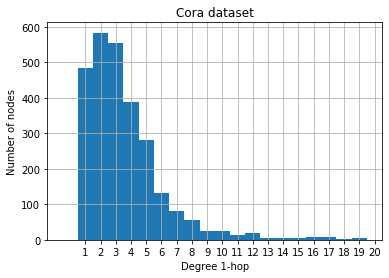

| No. of Nodes    | % of Nodes with degree 1-hop <= 20   | Average degree 1-hop| Max degree 1-hop| Label rate                            |
                         |-----------------|:-----------------------------------------:|--------------------------|----------------------|---------------------------------------|
                         |2708| 0.991|3.898  |168 | 0.052|

### Kernel before training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,False,(),float64,1
GraphKernelMultihop.base_kernel.offset,Parameter,Softplus,,True,(),float64,1


#### Training iteration rate: 4.913 iter/s

### Kernel after training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,False,(),float64,1
GraphKernelMultihop.base_kernel.offset,Parameter,Softplus,,True,(),float64,16.2496


### Results

Train acc: 100.0%

Test acc: 81.6%

In [7]:
experimentGGP(dataset="cora",max_iter=it,hops=1)

# Citeseer dataset 1-hop GGP

### Plot 

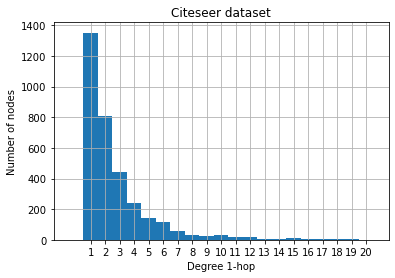

| No. of Nodes    | % of Nodes with degree 1-hop <= 20   | Average degree 1-hop| Max degree 1-hop| Label rate                            |
                         |-----------------|:-----------------------------------------:|--------------------------|----------------------|---------------------------------------|
                         |3327| 0.996|2.774  |99 | 0.036|

### Kernel before training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,False,(),float64,1
GraphKernelMultihop.base_kernel.offset,Parameter,Softplus,,True,(),float64,1


#### Training iteration rate: 4.534 iter/s

### Kernel after training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,False,(),float64,1
GraphKernelMultihop.base_kernel.offset,Parameter,Softplus,,True,(),float64,15.9011


### Results

Train acc: 100.0%

Test acc: 69.3%

In [8]:
experimentGGP(dataset="citeseer",max_iter=it,hops=1)

# Pubmed dataset 1-hop GGP

### Plot 

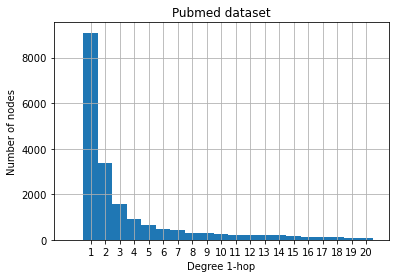

| No. of Nodes    | % of Nodes with degree 1-hop <= 20   | Average degree 1-hop| Max degree 1-hop| Label rate                            |
                         |-----------------|:-----------------------------------------:|--------------------------|----------------------|---------------------------------------|
                         |19717| 0.961|4.496  |171 | 0.003|

### Kernel before training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,False,(),float64,1
GraphKernelMultihop.base_kernel.offset,Parameter,Softplus,,True,(),float64,1


#### Training iteration rate: 22.446 iter/s

### Kernel after training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,False,(),float64,1
GraphKernelMultihop.base_kernel.offset,Parameter,Softplus,,True,(),float64,3.36849


### Results

Train acc: 100.0%

Test acc: 76.4%

In [9]:
experimentGGP(dataset="pubmed",max_iter=it,hops=1)

In [10]:
it=300 #reducing the iterations becouse computation slows down significantly

# Cora dataset 2-hop GGP

### Plot 

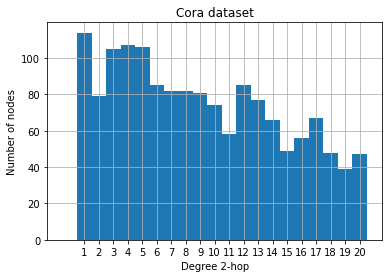

| No. of Nodes    | % of Nodes with degree 2-hop <= 20   | Average degree 2-hop| Max degree 2-hop| Label rate                            |
                         |-----------------|:-----------------------------------------:|--------------------------|----------------------|---------------------------------------|
                         |2708| 0.556|35.778  |425 | 0.052|

### Kernel before training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,False,(),float64,1
GraphKernelMultihop.base_kernel.offset,Parameter,Softplus,,True,(),float64,1


#### Training iteration rate: 0.689 iter/s

### Kernel after training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,False,(),float64,1
GraphKernelMultihop.base_kernel.offset,Parameter,Softplus,,True,(),float64,12.2353


### Results

Train acc: 98.57142857142858%

Test acc: 77.7%

In [11]:
experimentGGP(dataset="cora",max_iter=it,hops=2)

# Citeseer dataset 2-hop GGP

### Plot 

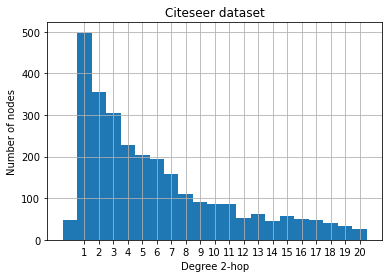

| No. of Nodes    | % of Nodes with degree 2-hop <= 20   | Average degree 2-hop| Max degree 2-hop| Label rate                            |
                         |-----------------|:-----------------------------------------:|--------------------------|----------------------|---------------------------------------|
                         |3327| 0.834|14.106  |261 | 0.036|

### Kernel before training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,False,(),float64,1
GraphKernelMultihop.base_kernel.offset,Parameter,Softplus,,True,(),float64,1


#### Training iteration rate: 0.687 iter/s

### Kernel after training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,False,(),float64,1
GraphKernelMultihop.base_kernel.offset,Parameter,Softplus,,True,(),float64,13.8947


### Results

Train acc: 99.16666666666667%

Test acc: 69.89999999999999%

In [12]:
experimentGGP(dataset="citeseer",max_iter=it,hops=2)

# Pubmed dataset 2-hop GGP

### Plot 

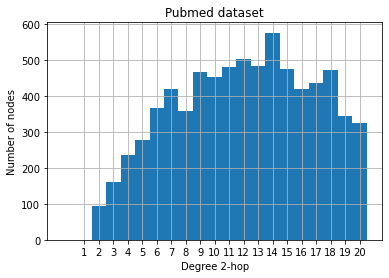

| No. of Nodes    | % of Nodes with degree 2-hop <= 20   | Average degree 2-hop| Max degree 2-hop| Label rate                            |
                         |-----------------|:-----------------------------------------:|--------------------------|----------------------|---------------------------------------|
                         |19717| 0.374|59.053  |2225 | 0.003|

### Kernel before training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,False,(),float64,1
GraphKernelMultihop.base_kernel.offset,Parameter,Softplus,,True,(),float64,1


#### Training iteration rate: 1.991 iter/s

### Kernel after training

name,class,transform,prior,trainable,shape,dtype,value
GraphKernelMultihop.base_kernel.variance,Parameter,Softplus,,False,(),float64,1
GraphKernelMultihop.base_kernel.offset,Parameter,Softplus,,True,(),float64,2.07105


### Results

Train acc: 98.33333333333333%

Test acc: 76.0%

In [13]:
experimentGGP(dataset="pubmed",max_iter=it,hops=2)